# Random Forest on Yearly Aggregates
<a id='top'></a>

<a href=#readdata>Read Data</a>  

<a href=#features>Feature Selection</a>

<a href=#dt>Random Forest</a>

<a href=#inspectfeatures>Inspect Features</a>

<a href=#dummy>One Hot Encode</a>

<a href=#balancedata>Balance Data</a>

<a href=#dt_rebalance>Random Forest on Re-Balance Data</a>

<a href=#plot>Plot ROC Curve</a>

<a href=#bottom>Bottom</a>


## Questions:

has_relocated_this_year

has_relocated_next_year has null values

reading in directly from bucket



In [2]:
# Ignore 'dask' warning
import pandas as pd
import gcsfs
from google.cloud import storage
from pandas import DataFrame
from IPython.display import HTML
from google.cloud.storage import Blob
import datalab.storage as gcs_datalab
from datetime import date
import numpy as np

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import sem
import pickle


from matplotlib import pyplot
import seaborn as sns
from scipy import stats

<a id='readdata'></a>
# Read Yearly Aggregated Data 
<a href=#top>Top</a>

In [3]:
data_df0 = pd.read_csv('2017_aggregated.csv')

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data_df0.shape

(1966208, 59)

In [5]:
data_df1 = pd.read_csv('2016_aggregated.csv')

In [6]:
data_df1.shape

(1930102, 59)

In [7]:
data_df2 = pd.read_csv('2015_aggregated.csv')

In [8]:
data_df2.shape

(1890941, 59)

In [13]:
data_df0.columns.difference(data_df1.columns)

Index([], dtype='object')

In [14]:
data_df2.columns.difference(data_df1.columns)

Index([], dtype='object')

In [15]:
data_df = data_df0.append(data_df1).append(data_df2)

In [20]:
data_df0.shape[0]+data_df1.shape[0]+data_df2.shape[0], data_df.shape[0]

(5787251, 5787251)

In [21]:
data_df.columns

Index(['Unnamed: 0', 'id_branch', 'id_company', 'date_month', 'code_sbi_1',
       'has_relocated', 'has_name_change', 'delta_qty_employees',
       'delta_qty_issued_credit_reports', 'delta_score_payment_assessment',
       'code_legal_form_has_changed', 'SBI_has_changed', 'company_age',
       'years_since_last_amt_consolidated_operating_result',
       'years_since_last_amt_consolidated_revenue',
       'years_since_last_amt_operating_result',
       'years_since_last_qty_employees', 'years_since_last_amt_revenue',
       'years_in_current_location',
       'ratio_operating_result_consolidated_operating_result',
       'ratio_revenue_consolidated_revenue', 'unique_id', 'qty_green_flags',
       'qty_orange_flags', 'qty_red_flags', 'A', 'AA', 'AAA', 'B', 'BB', 'BBB',
       'C', 'CC', 'CCC', 'D', 'NR', 'code_legal_form_group_1',
       'code_legal_form_group_2', 'SBI_group_1', 'SBI_group_2',
       'is_discontinued_any', 'has_financial_calamity',
       'mean_amt_consolidated_operati

## Check Distribution of Target:

In [28]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    5327484
True      236577
Name: has_relocated_next_year, dtype: int64 
 False    0.920555
True     0.040879
Name: has_relocated_next_year, dtype: float64


In [181]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    5550674
True      236577
Name: has_relocated_next_year, dtype: int64 
 False    0.959121
True     0.040879
Name: has_relocated_next_year, dtype: float64


In [180]:
print(data_df.has_relocated.value_counts(), '\n',
data_df.has_relocated.value_counts() / data_df.shape[0])

False    5752269
True       34982
Name: has_relocated, dtype: int64 
 False    0.993955
True     0.006045
Name: has_relocated, dtype: float64


In [22]:
sum(data_df.has_relocated_next_year.isna())

223190

In [29]:
data_df[data_df.has_relocated_next_year.isna()] = 0

In [30]:
sum(data_df.has_relocated_next_year.isna())

0

In [31]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    5550674
True      236577
Name: has_relocated_next_year, dtype: int64 
 False    0.959121
True     0.040879
Name: has_relocated_next_year, dtype: float64


In [32]:
HTML(DataFrame(data_df).head(10).to_html())

,Unnamed: 0,id_branch,id_company,date_month,code_sbi_1,has_relocated,has_name_change,delta_qty_employees,delta_qty_issued_credit_reports,delta_score_payment_assessment,code_legal_form_has_changed,SBI_has_changed,company_age,years_since_last_amt_consolidated_operating_result,years_since_last_amt_consolidated_revenue,years_since_last_amt_operating_result,years_since_last_qty_employees,years_since_last_amt_revenue,years_in_current_location,ratio_operating_result_consolidated_operating_result,ratio_revenue_consolidated_revenue,unique_id,qty_green_flags,qty_orange_flags,qty_red_flags,A,AA,AAA,B,BB,BBB,C,CC,CCC,D,NR,code_legal_form_group_1,code_legal_form_group_2,SBI_group_1,SBI_group_2,is_discontinued_any,has_financial_calamity,mean_amt_consolidated_operating_result,mean_amt_consolidated_revenue,mean_amt_operating_result,mean_amt_revenue,mean_qty_employees,mean_qty_issued_credit_reports,mean_score_payment_assessment,mean_score_pd,qty_address_mutations_year,qty_started_names_year,qty_stopped_names_year,qty_board_changes_year,variance_qty_employees,variance_qty_issued_credit_reports,variance_score_payment_assessment,variance_score_pd,has_relocated_next_year
0,0,0,428134.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_428134.0,0,0,12,0,0,0,12,0,0,0,0,0,0,0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
1,1,0,803351.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_803351.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
2,2,0,810695.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_810695.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
3,3,0,811258.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_811258.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
4,4,0,811333.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_811333.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
5,5,0,818258.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_818258.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
6,6,0,823722.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_823722.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
7,7,0,829630.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_829630.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
8,8,0,834432.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_834432.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
9,9,0,834909.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_834909.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False


In [34]:
data_df.groupby('date_month')['date_month'].nunique()

date_month
0             1
2015-01-01    1
2015-02-01    1
2015-03-01    1
2015-04-01    1
2015-05-01    1
2015-06-01    1
2015-07-01    1
2015-08-01    1
2015-09-01    1
2015-10-01    1
2015-11-01    1
2015-12-01    1
2016-01-01    1
2016-02-01    1
2016-03-01    1
2016-04-01    1
2016-05-01    1
2016-06-01    1
2016-07-01    1
2016-08-01    1
2016-09-01    1
2016-10-01    1
2016-11-01    1
2016-12-01    1
2017-01-01    1
2017-02-01    1
2017-03-01    1
2017-04-01    1
2017-05-01    1
2017-06-01    1
2017-07-01    1
2017-08-01    1
2017-09-01    1
2017-10-01    1
2017-11-01    1
2017-12-01    1
Name: date_month, dtype: int64

<a id='features'></a>
# Feature Selection:

<a href=#top>Top</a>

In [37]:
print(data_df.isnull().sum())

Unnamed: 0                                                    0
id_branch                                                     0
id_company                                                    0
date_month                                                    0
code_sbi_1                                              5550351
has_relocated                                                 0
has_name_change                                               0
delta_qty_employees                                      850447
delta_qty_issued_credit_reports                               0
delta_score_payment_assessment                                0
code_legal_form_has_changed                                   0
SBI_has_changed                                               0
company_age                                               88210
years_since_last_amt_consolidated_operating_result      5408767
years_since_last_amt_consolidated_revenue               5462470
years_since_last_amt_operating_result   

In [48]:
type(features_to_exclude)

list

In [82]:
features_to_exclude = ('Unnamed: 0', 
                       'id_branch',
                       'id_company',
                       'date_month',
                       'unique_id',
                       'code_sbi_1',
                       'has_relocated',
                       #'has_name_change',
                       'delta_qty_employees',
                       #'delta_qty_issued_credit_reports', 
                       #'delta_score_payment_assessment',
                       #'code_legal_form_has_changed',
                       #'SBI_has_changed',
                       #'company_age',
                       'years_since_last_amt_consolidated_operating_result',
                       'years_since_last_amt_consolidated_revenue',
                       'years_since_last_amt_operating_result',
                       'years_since_last_qty_employees',
                       'years_since_last_amt_revenue',
                       'years_in_current_location',
                       'ratio_operating_result_consolidated_operating_result',
                       'ratio_revenue_consolidated_revenue',
                       #'qty_green_flags',
                       #'qty_orange_flags',
                       #'qty_red_flags',
                       #'A',
                       #'AA',
                       #'AAA',
                       #'B',
                       #'BB',
                       #'BBB',
                       #'C',
                       #'CC',
                       #'CCC',
                       #'D',
                       #'NR',
                       #'code_legal_form_group_1',
                       #'code_legal_form_group_2',
                       #'SBI_group_1',
                       #'SBI_group_2',
                       #'is_discontinued_any',
                       #'has_financial_calamity',
                       'mean_amt_consolidated_operating_result',
                       'mean_amt_consolidated_revenue',
                       'mean_amt_operating_result',
                       'mean_amt_revenue',
                       'mean_qty_employees',
                       #'mean_qty_issued_credit_reports',
                       #'mean_score_payment_assessment',
                       'mean_score_pd',
                       #'qty_address_mutations_year',
                       #'qty_started_names_year',
                       #'qty_stopped_names_year',
                       #'qty_board_changes_year',
                       'variance_qty_employees',
                       #'variance_qty_issued_credit_reports',
                       #'variance_score_payment_assessment',
                       #'variance_score_pd',
                       'has_relocated_next_year'
                      )

features_in_model = [feature for feature in data_df.columns.tolist() 
                     if feature not in features_to_exclude]


In [83]:
features_in_model

['has_name_change',
 'delta_qty_issued_credit_reports',
 'delta_score_payment_assessment',
 'code_legal_form_has_changed',
 'SBI_has_changed',
 'company_age',
 'qty_green_flags',
 'qty_orange_flags',
 'qty_red_flags',
 'A',
 'AA',
 'AAA',
 'B',
 'BB',
 'BBB',
 'C',
 'CC',
 'CCC',
 'D',
 'NR',
 'code_legal_form_group_1',
 'code_legal_form_group_2',
 'SBI_group_1',
 'SBI_group_2',
 'is_discontinued_any',
 'has_financial_calamity',
 'mean_qty_issued_credit_reports',
 'mean_score_payment_assessment',
 'qty_address_mutations_year',
 'qty_started_names_year',
 'qty_stopped_names_year',
 'qty_board_changes_year',
 'variance_qty_issued_credit_reports',
 'variance_score_payment_assessment',
 'variance_score_pd']

In [84]:
data_to_model = data_df[features_in_model + ['has_relocated_next_year']]

In [85]:
data_to_model.shape

(5787251, 36)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [86]:
data_to_model.isnull().values.any()

True

In [87]:
print(data_to_model.isnull().sum())

has_name_change                           0
delta_qty_issued_credit_reports           0
delta_score_payment_assessment            0
code_legal_form_has_changed               0
SBI_has_changed                           0
company_age                           88210
qty_green_flags                           0
qty_orange_flags                          0
qty_red_flags                             0
A                                         0
AA                                        0
AAA                                       0
B                                         0
BB                                        0
BBB                                       0
C                                         0
CC                                        0
CCC                                       0
D                                         0
NR                                        0
code_legal_form_group_1                   0
code_legal_form_group_2                   0
SBI_group_1                     

Drop NA rows:

In [88]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(5671762, 36)


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [89]:
data_to_model.isnull().values.any()

False

<a id='dt'></a>
# Random Forest:

<a href=#top>Top</a>

In [102]:
data_to_model.to_csv('data_to_model.csv')

In [90]:
x_train, x_test, y_train, y_test = train_test_split(data_to_model[features_in_model], data_to_model.has_relocated_next_year, 
                                                    test_size=0.20, random_state=0)
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [91]:
print(y_train.value_counts(), '\n', y_train.value_counts() / y_train.shape[0])

0    4350148
1     187261
Name: has_relocated_next_year, dtype: int64 
 0    0.95873
1    0.04127
Name: has_relocated_next_year, dtype: float64


In [92]:
#clf0 = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=0)

#clf0.fit(x_train, y_train)  



clf0 = RandomForestClassifier()

clf0.fit(x_train, y_train)  


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [94]:
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.977 



In [57]:
clf0.feature_importances_

array([7.98726674e-02, 1.71653048e-02, 1.09944135e-03, 1.59607161e-02,
       7.00909130e-03, 1.18175163e-02, 2.28704731e-02, 1.82864190e-02,
       1.11557133e-02, 2.39814579e-02, 2.74373935e-02, 2.86794189e-02,
       1.61678157e-03, 1.04670155e-02, 1.97311296e-02, 1.82942854e-03,
       1.50775760e-03, 1.34834740e-01, 6.78267406e-03, 1.18827511e-02,
       7.89482196e-03, 2.81875690e-04, 1.75814187e-03, 8.21171843e-04,
       9.82029210e-04, 0.00000000e+00, 7.46643917e-03, 0.00000000e+00,
       5.29704812e-02, 1.92464051e-02, 1.68570379e-02, 1.76689585e-01,
       1.86832419e-02, 6.73913682e-03, 3.26956194e-05, 1.91986077e-02,
       2.13678911e-02, 1.92682760e-02, 1.75754270e-01])

## Save Model:

In [93]:
filename = 'models/RF_defaults_unbalanced.sav'
pickle.dump(clf0, open(filename, 'wb'))

## Tune Model Parameters

<a href=#top>Top</a>

In [60]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,7,8],
    'criterion' :['gini', 'entropy']
}

clf00 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5, n_jobs=4)
clf00.fit(X=x_train, y=y_train)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [59]:
parameters = {'max_depth':range(3,20), 'min_samples_split':range(5, 20)}
clf00 = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4, cv = 3)
clf00.fit(X=x_train, y=y_train)
clf0 = clf00.best_estimator_
print (clf00.best_score_, clf00.best_params_)

0.9519634442998275 {'min_samples_split': 5, 'max_depth': 6}


In [60]:
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.952 



In [95]:
clf0

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [96]:
y_pred=clf0.predict(x_test)

In [97]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1080253,    7103],
       [  46039,     958]])

In [98]:
score=metrics.accuracy_score(y_test, y_pred)

# Get probabilities
y_probs = clf0.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

In [99]:
score, auc, kappa

(0.9531521492868622, 0.597540312163634, 0.02294637891083251)

In [100]:
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98   1087356
           1       0.12      0.02      0.03     46997

   micro avg       0.95      0.95      0.95   1134353
   macro avg       0.54      0.51      0.51   1134353
weighted avg       0.92      0.95      0.94   1134353



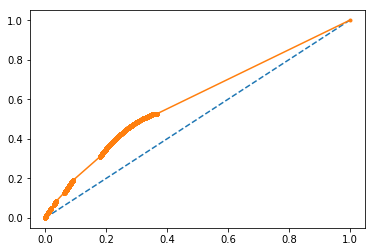

In [101]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='balancedata'></a>
## Balance Data:

<a href=#top>Top</a>

In [104]:
train_all = x_train

In [105]:
train_all.columns

Index(['has_name_change', 'delta_qty_issued_credit_reports',
       'delta_score_payment_assessment', 'code_legal_form_has_changed',
       'SBI_has_changed', 'company_age', 'qty_green_flags', 'qty_orange_flags',
       'qty_red_flags', 'A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'C', 'CC', 'CCC',
       'D', 'NR', 'code_legal_form_group_1', 'code_legal_form_group_2',
       'SBI_group_1', 'SBI_group_2', 'is_discontinued_any',
       'has_financial_calamity', 'mean_qty_issued_credit_reports',
       'mean_score_payment_assessment', 'qty_address_mutations_year',
       'qty_started_names_year', 'qty_stopped_names_year',
       'qty_board_changes_year', 'variance_qty_issued_credit_reports',
       'variance_score_payment_assessment', 'variance_score_pd'],
      dtype='object')

In [106]:
train_all['has_relocated_next_year'] = y_train

In [107]:
train_all.shape

(4537409, 36)

In [108]:
train_all.has_relocated_next_year.value_counts() / train_all.shape[0]

0    0.95873
1    0.04127
Name: has_relocated_next_year, dtype: float64

In [109]:
# Choose desired class breakdown
fraction_majority = 0.50

In [110]:
num_minority = train_all[train_all['has_relocated_next_year']==True].shape[0]

num_majority = fraction_majority * num_minority / (1 - fraction_majority)

num_minority, int(num_majority), num_majority, num_majority/(num_majority + num_minority)

(187261, 187261, 187261.0, 0.5)

In [111]:
# Separate majority and minority classes
df_majority = train_all[train_all.has_relocated_next_year==False]
df_minority = train_all[train_all.has_relocated_next_year==True]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(num_majority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.has_relocated_next_year.value_counts()

1    187261
0    187261
Name: has_relocated_next_year, dtype: int64

In [112]:
df_downsampled.has_relocated_next_year.value_counts()/df_downsampled.shape[0]

1    0.5
0    0.5
Name: has_relocated_next_year, dtype: float64

In [113]:
df_downsampled.shape

(374522, 36)

In [114]:
data_df.shape

(5787251, 59)

## Remove NaNs from Balanced Dataset:

In [115]:
data_to_model = df_downsampled[features_in_model + ['has_relocated_next_year']]

In [116]:
data_to_model.shape

(374522, 36)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [117]:
data_to_model.isnull().values.any()

False

In [118]:
print(data_to_model.isnull().sum())

has_name_change                       0
delta_qty_issued_credit_reports       0
delta_score_payment_assessment        0
code_legal_form_has_changed           0
SBI_has_changed                       0
company_age                           0
qty_green_flags                       0
qty_orange_flags                      0
qty_red_flags                         0
A                                     0
AA                                    0
AAA                                   0
B                                     0
BB                                    0
BBB                                   0
C                                     0
CC                                    0
CCC                                   0
D                                     0
NR                                    0
code_legal_form_group_1               0
code_legal_form_group_2               0
SBI_group_1                           0
SBI_group_2                           0
is_discontinued_any                   0


Drop rows with NA:

In [80]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(180434, 40)


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [81]:
data_to_model.isnull().values.any()

False

<a id='dt_rebalance'></a>

# Random Forest on Re-balanced data

<a href=#top>Top</a>

In [119]:
x_re_train, x_re_test, y_re_train, y_re_test = train_test_split(data_to_model[features_in_model], 
                                                                data_to_model.has_relocated_next_year, 
                                                    test_size=0.25, random_state=0)

y_re_train=y_re_train.astype('int')
y_re_test=y_re_test.astype('int')

In [120]:
x_train.shape

(4537409, 36)

In [121]:
x_re_train.shape

(280891, 35)

In [122]:
clf = RandomForestClassifier(n_estimators=100, max_depth=6,random_state=0, min_samples_split=5)

clf.fit(x_re_train, y_re_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [124]:
clf = RandomForestClassifier()

clf.fit(x_re_train, y_re_train)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [125]:
measure_performance(x_re_train,y_re_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.906 



In [123]:
measure_performance(x_re_train,y_re_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.624 



## Save Model

In [126]:
filename = 'models/RF_defaults_balanced.sav'
pickle.dump(clf, open(filename, 'wb'))

## Model Tuning:

In [158]:
RandomForestClassifier?

In [160]:
x_train.shape

(4537409, 36)

In [163]:
#parameters = {'n_estimators':range(50,120)}

parameters = {'max_depth':range(15, 25), 'min_samples_leaf':[5, 10, 15], 'min_samples_split':range(2, 10)}
clfB = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=4)
clfB.fit(X=x_re_train, y=y_re_train)
clf_RF = clfB.best_estimator_
print (clfB.best_score_, clfB.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6407681271382849 {'min_samples_split': 7, 'max_depth': 21, 'min_samples_leaf': 15}


In [165]:
filename = 'models/RF_md15_25_msl5_15_mss2_10_balanced.sav'
pickle.dump(clf_RF, open(filename, 'wb'))

In [166]:
y_re_pred=clf_RF.predict(x_re_test)

In [170]:
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[25323, 21839],
       [11526, 34943]])

In [173]:
score=metrics.accuracy_score(y_re_test, y_re_pred)

# Get probabilities
y_re_probs = clf_RF.predict_proba(x_re_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_re_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_re_test, y_re_pred)
cr=metrics.classification_report(y_re_test, y_re_pred)

In [174]:
score, auc, kappa

(0.6436543452489026, 0.7038267694654605, 0.2884298935532571)

In [130]:
score, auc, kappa

(0.6127671390885497, 0.6623778148516803, 0.22538909741547575)

In [131]:
print(cr)

              precision    recall  f1-score   support

           0       0.61      0.62      0.62     47162
           1       0.61      0.60      0.61     46469

   micro avg       0.61      0.61      0.61     93631
   macro avg       0.61      0.61      0.61     93631
weighted avg       0.61      0.61      0.61     93631



<a id='plot'></a>
# Plot

<a href=#top>Top</a>


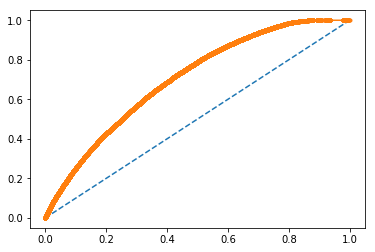

In [175]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

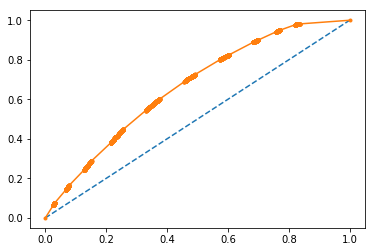

In [132]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

## Verify on Un-balanced test set:

<a href=#top>Top</a>

In [133]:
x_test.shape

(1134353, 35)

In [176]:
y_re_pred_unbalance=clf_RF.predict(x_test)

In [135]:
y_re_pred_unbalance.shape

(1134353,)

In [136]:
cnf_matrix = metrics.confusion_matrix(y_test, y_re_pred_unbalance)
cnf_matrix

array([[677794, 409562],
       [ 18701,  28296]])

In [156]:
sum(y_test) / len(y_test), sum(y_test==0) / len(y_test) 

(0.04143066576277402, 0.958569334237226)

In [177]:
sum(y_re_pred_unbalance==1) / len(y_re_pred_unbalance), sum(y_re_pred_unbalance!=1) / len(y_re_pred_unbalance)

(0.47411960827008875, 0.5258803917299112)

In [157]:
sum(y_re_pred_unbalance==1) / len(y_re_pred_unbalance), sum(y_re_pred_unbalance!=1) / len(y_re_pred_unbalance)

(0.3859980094379792, 0.6140019905620209)

In [178]:
score=metrics.accuracy_score(y_test, y_re_pred_unbalance)

# Get probabilities
y_re_probs = clf_RF.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_test, y_re_pred_unbalance)
cr=metrics.classification_report(y_test, y_re_pred_unbalance)

In [179]:
score, auc, kappa

(0.54659263915201, 0.7033809747910406, 0.047991716204711876)

In [138]:
score, auc, kappa

(0.6224605568107987, 0.6622682287575188, 0.04527798222695878)

In [139]:
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.62      0.76   1087356
           1       0.06      0.60      0.12     46997

   micro avg       0.62      0.62      0.62   1134353
   macro avg       0.52      0.61      0.44   1134353
weighted avg       0.94      0.62      0.73   1134353



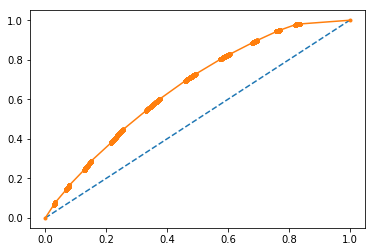

In [140]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

NameError: name 'plt' is not defined

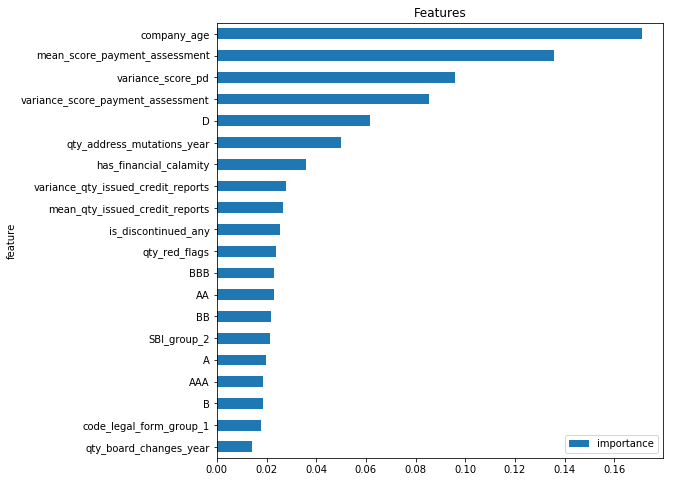

In [169]:
feat_imp = pd.DataFrame({'importance':clf_RF.feature_importances_})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:20]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()